In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

In [2]:
f = "user_behavior_dataset.csv"
df = pd.read_csv(f, low_memory=False)

In [3]:
df.describe()

,User ID,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class
count,700.00000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,350.50000,271.128571,5.272714,1525.158571,50.681429,929.742857,38.482857,2.990000
std,202.21688,177.199484,3.068584,819.136414,26.943324,640.451729,12.012916,1.401476
min,1.00000,30.000000,1.000000,302.000000,10.000000,102.000000,18.000000,1.000000
25%,175.75000,113.250000,2.500000,722.250000,26.000000,373.000000,28.000000,2.000000
50%,350.50000,227.500000,4.900000,1502.500000,49.000000,823.500000,38.000000,3.000000
75%,525.25000,434.250000,7.400000,2229.500000,74.000000,1341.000000,49.000000,4.000000
max,700.00000,598.000000,12.000000,2993.000000,99.000000,2497.000000,59.000000,5.000000


In [4]:
df.columns

Index(['User ID', 'Device Model', 'Operating System',
       'App Usage Time (min/day)', 'Screen On Time (hours/day)',
       'Battery Drain (mAh/day)', 'Number of Apps Installed',
       'Data Usage (MB/day)', 'Age', 'Gender', 'User Behavior Class'],
      dtype='object')

## Exploratory Data Analysis

In [5]:
# Check for missing values
df.isna().sum()

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

In [6]:
# Drop rows containing the missing values for age
df.dropna(inplace=True)

In [7]:
# Group the features
numerical_features = ['App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Number of Apps Installed', 'Data Usage (MB/day)', 'Age']
categorical_features = ['Device Model', 'Operating System', 'Gender']

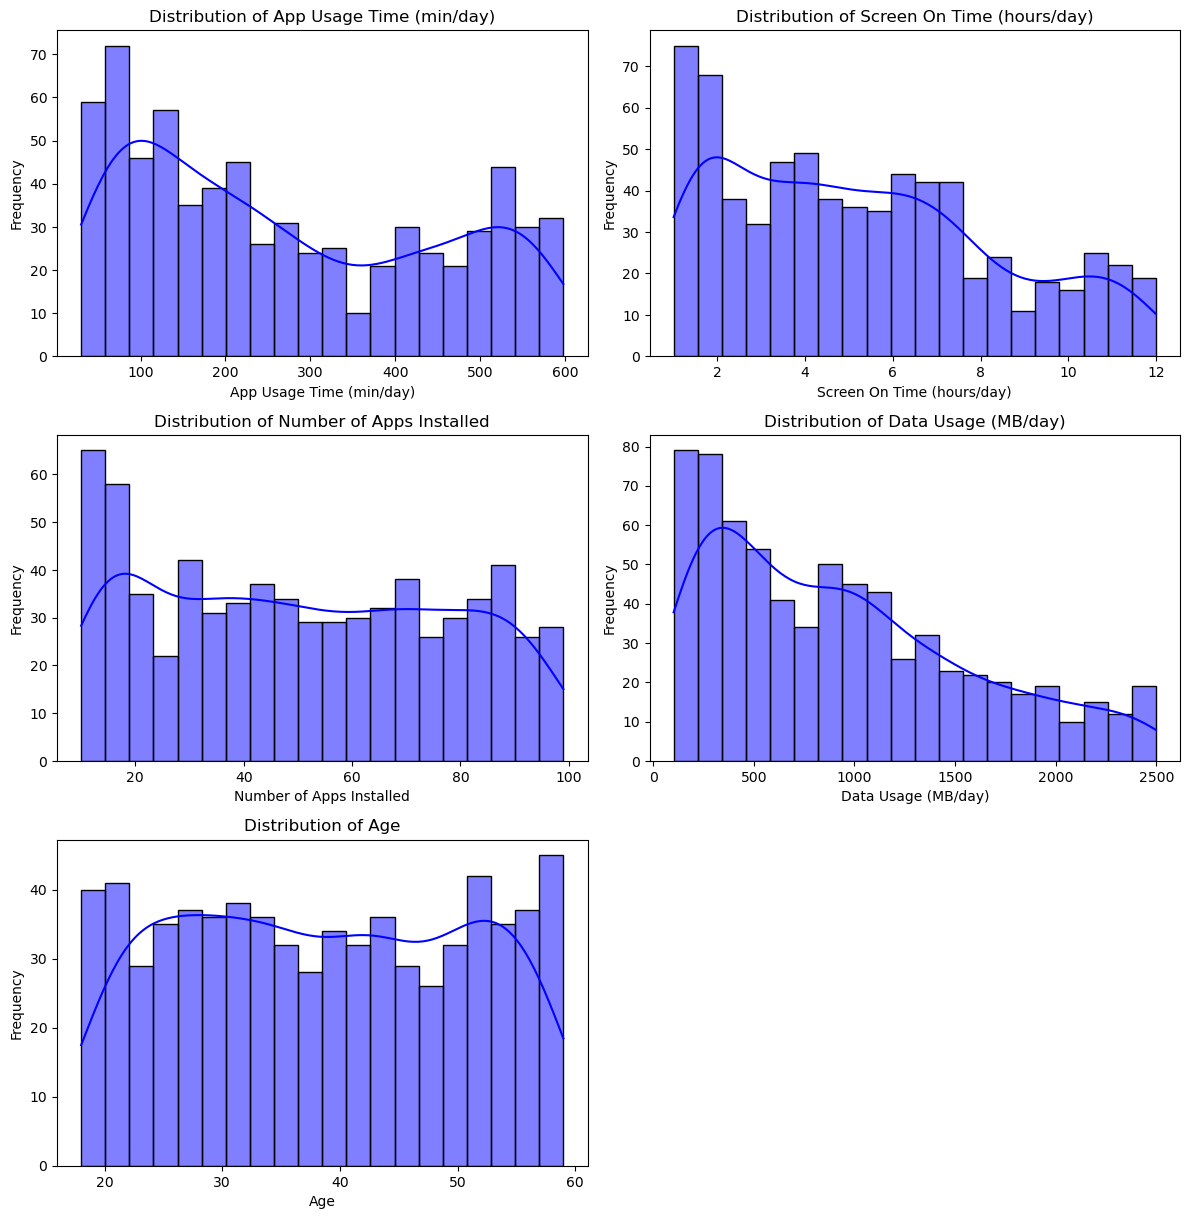

In [8]:
# Let's start looking at the distribution of numerical features
# Num of numerical features
num_features = len(numerical_features)

# Get the dimensions of the grid w/ 2 cols
n_cols = 2
n_rows = (num_features + n_cols -1)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

# Flatten the axes
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=df, x=feature, kde=True, bins=20, color='blue', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

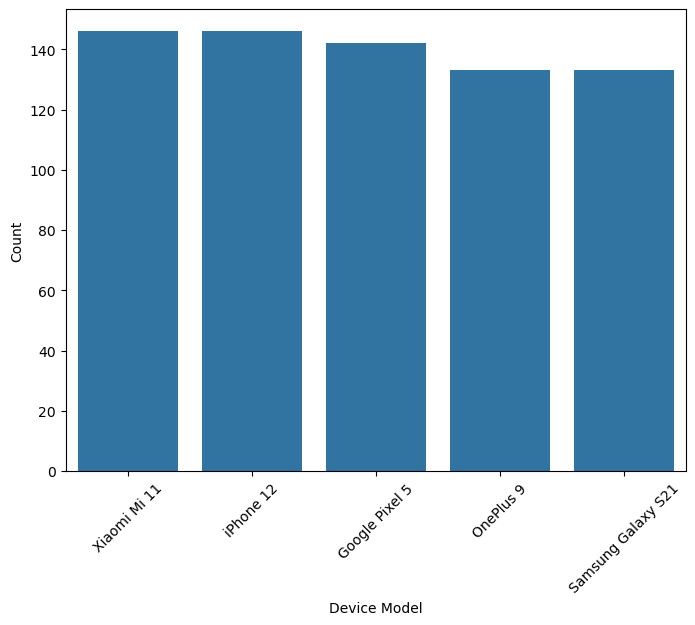

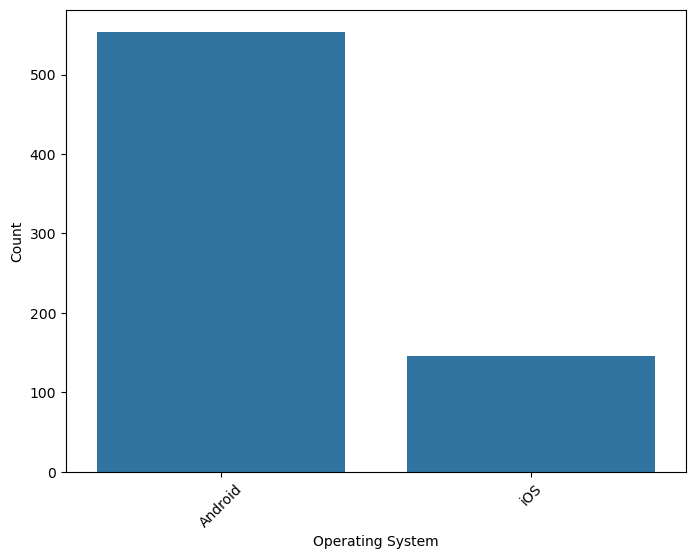

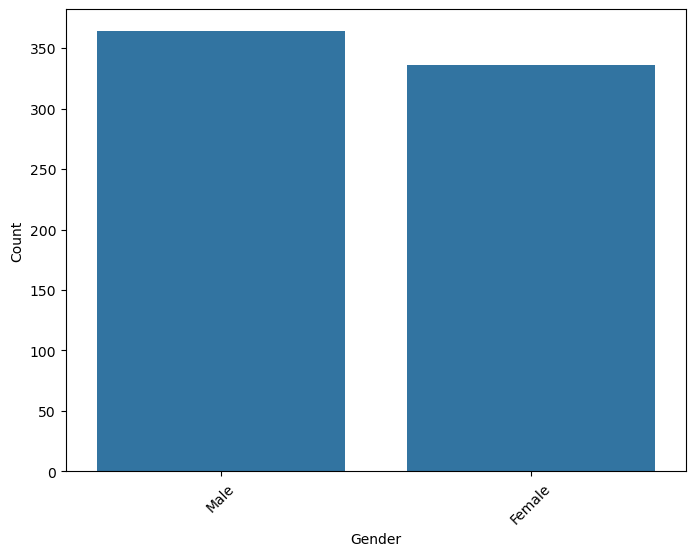

In [9]:
# Now the categorical features
for feature in categorical_features:
    plt.figure(figsize=(8,6))
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, legend=False)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

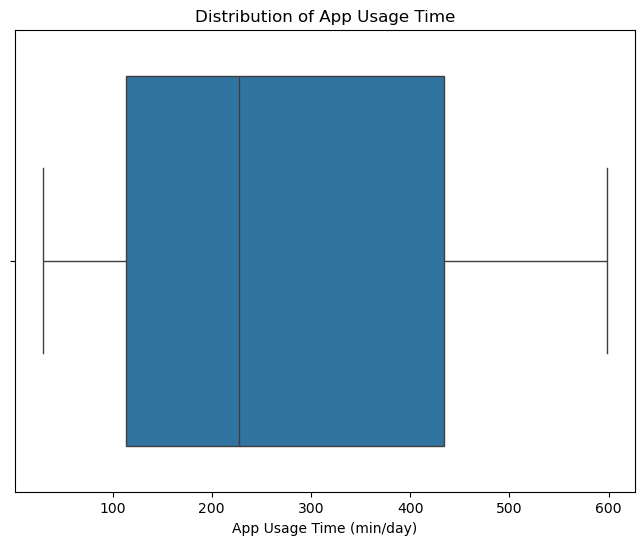

In [10]:
# Boxplot of App Usage Time
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='App Usage Time (min/day)')
plt.title('Distribution of App Usage Time')
plt.xlabel('App Usage Time (min/day)')
plt.show()

In [11]:
# Bins for the Age column
bins = [18, 29, 39, 49, 59]
df['Age Group'] = pd.cut(df['Age'], bins=bins)
df

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class,Age Group
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4,"(39, 49]"
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3,"(39, 49]"
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2,"(39, 49]"
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3,"(18, 29]"
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3,"(29, 39]"
...,...,...,...,...,...,...,...,...,...,...,...,...
695,696,iPhone 12,iOS,92,3.9,1082,26,381,22,Male,2,"(18, 29]"
696,697,Xiaomi Mi 11,Android,316,6.8,1965,68,1201,59,Male,4,"(49, 59]"
697,698,Google Pixel 5,Android,99,3.1,942,22,457,50,Female,2,"(49, 59]"
698,699,Samsung Galaxy S21,Android,62,1.7,431,13,224,44,Male,1,"(39, 49]"


## Which Age Group Has the Highest App Usage Time?

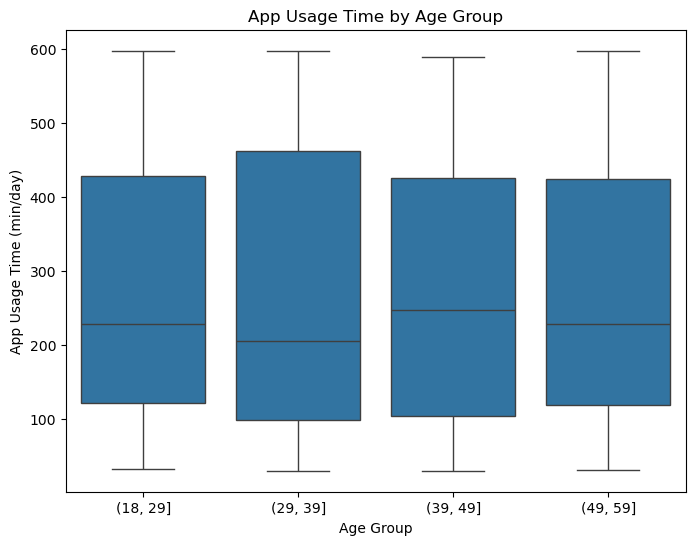

In [12]:
# App Usage Time by Age

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Age Group', y='App Usage Time (min/day)')
plt.title('App Usage Time by Age Group')
plt.xlabel('Age Group')
plt.ylabel('App Usage Time (min/day)')
plt.show()

## Are there any differences in app usage time between genders?


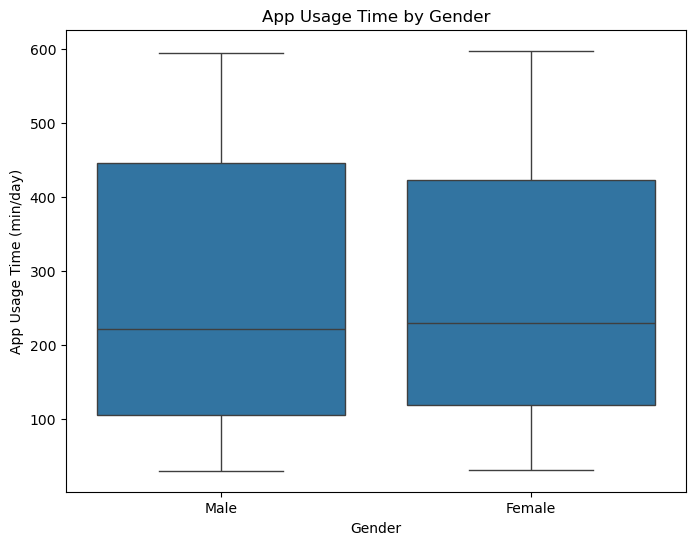

In [13]:
# App Usage Time by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Gender', y='App Usage Time (min/day)')
plt.title('App Usage Time by Gender')
plt.xlabel('Gender')
plt.ylabel('App Usage Time (min/day)')
plt.show()

## How does daily screen time correlate with app usage time?

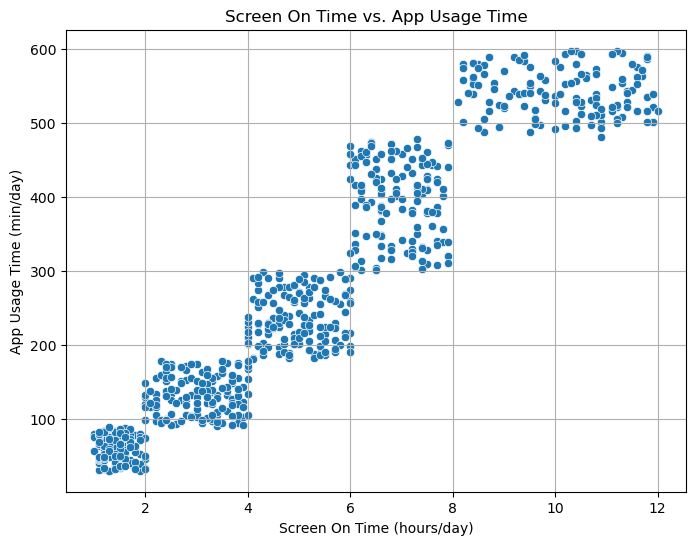

In [14]:
# Scatterplot of daily screen time vs app usage time
plt.figure(figsize=(8,6))
sns.scatterplot(x='Screen On Time (hours/day)', y='App Usage Time (min/day)', data=df)
plt.title('Screen On Time vs. App Usage Time')
plt.xlabel('Screen On Time (hours/day)')
plt.ylabel('App Usage Time (min/day)')
plt.grid(True)
plt.show()

## Do heavier app users use significantly more data?


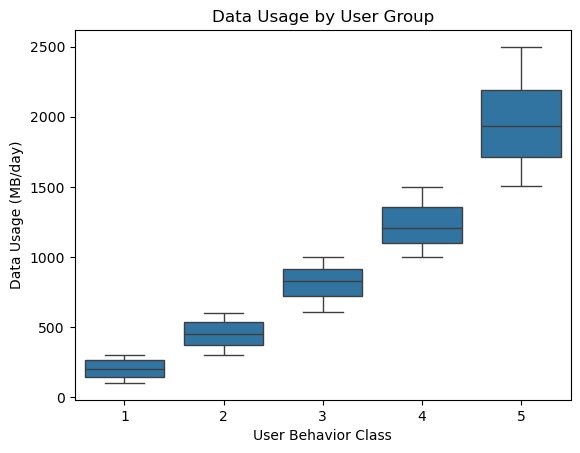

In [15]:
# Boxplot of Data Usage by User Group
sns.boxplot(x='User Behavior Class', y='Data Usage (MB/day)', data=df)
plt.title('Data Usage by User Group')
plt.show()

In [16]:

# Group users into heavier and lighter data usage groups
df['User Group'] = df['User Behavior Class'].apply(lambda x: 'Heavier' if x >= 4 else 'Lighter')

# Group Data
heavier_users = df[df['User Group'] == 'Heavier']['Data Usage (MB/day)']
lighter_users = df[df['User Group'] == 'Lighter']['Data Usage (MB/day)']

# Summary Statistics
print(f'Heavier Usage Group Data Consumption: \n{heavier_users.describe()}')
print(f'Lighter Usage Group Data Consumption: \n{lighter_users.describe()}')


Heavier Usage Group Data Consumption: 
count     275.000000
mean     1599.450909
std       438.960967
min      1002.000000
25%      1209.000000
50%      1493.000000
75%      1931.500000
max      2497.000000
Name: Data Usage (MB/day), dtype: float64
Lighter Usage Group Data Consumption: 
count    425.000000
mean     496.402353
std      269.391401
min      102.000000
25%      266.000000
50%      457.000000
75%      723.000000
max      997.000000
Name: Data Usage (MB/day), dtype: float64


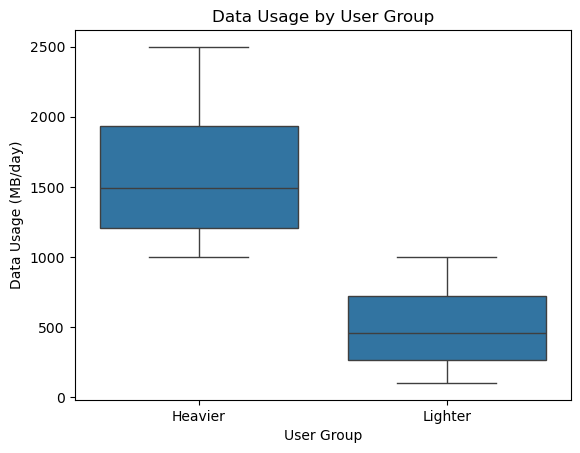

In [17]:
# User Group Boxplot
sns.boxplot(x='User Group', y='Data Usage (MB/day)', data=df)
plt.title('Data Usage by User Group')
plt.show()

In [18]:
t_stat, p_value = ttest_ind(heavier_users, lighter_users, equal_var=False)
print(f'T-Test: t-statistic = {t_stat}, p-value = {p_value}')

if p_value < 0.05:
    print('Conclusion: Heavier app users consume significantly more data compared to lighter app users.')
else:
    print('Conclusion: There is no significant difference in data consumption between heavier and lighter app users.')

T-Test: t-statistic = 37.36602293628329, p-value = 8.29848208005354e-134
Conclusion: Heavier app users consume significantly more data compared to lighter app users.


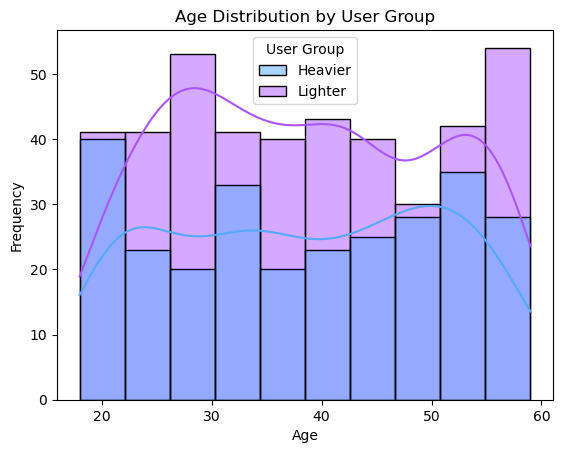

In [19]:
# Histogram of Age by User Group
sns.histplot(data=df, x='Age', hue='User Group', kde=True, palette='cool', bins=10)
plt.title('Age Distribution by User Group')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

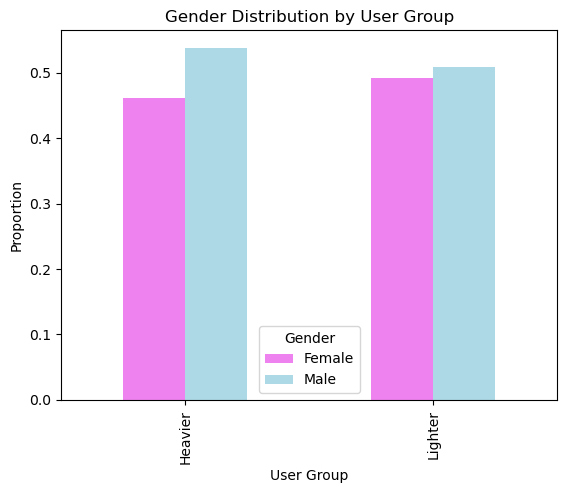

In [20]:
gender_counts = df.groupby('User Group')['Gender'].value_counts(normalize=True).unstack()
gender_counts.plot(kind='bar', stacked=False, color=['violet', 'lightblue'])
plt.title('Gender Distribution by User Group')
plt.xlabel('User Group')
plt.ylabel('Proportion')
plt.legend(title='Gender')
plt.show()

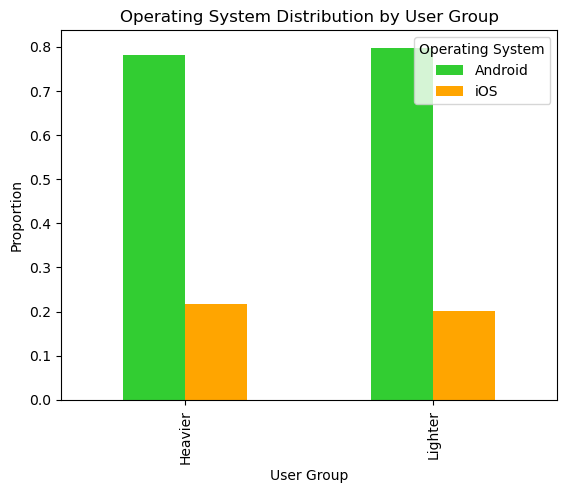

In [21]:
os_counts = df.groupby('User Group')['Operating System'].value_counts(normalize=True).unstack()
os_counts.plot(kind='bar', stacked=False, color=['limegreen', 'orange'])
plt.title('Operating System Distribution by User Group')
plt.xlabel('User Group')
plt.ylabel('Proportion')
plt.legend(title='Operating System')
plt.show()

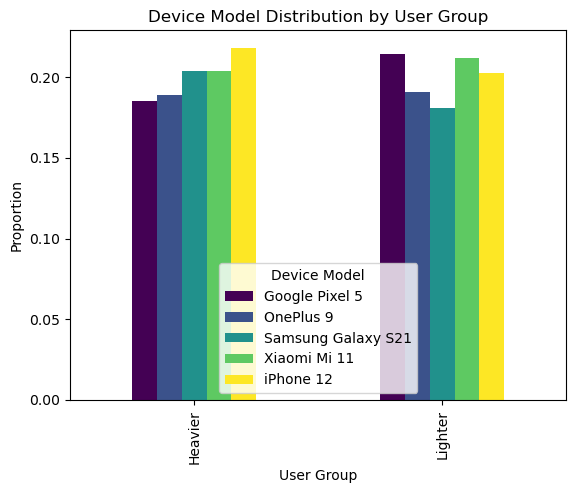

In [22]:
model_counts = df.groupby('User Group')['Device Model'].value_counts(normalize=True).unstack()
model_counts.plot(kind='bar', stacked=False, colormap=sns.color_palette('viridis', as_cmap=True))
plt.title('Device Model Distribution by User Group')
plt.xlabel('User Group')
plt.ylabel('Proportion')
plt.show()

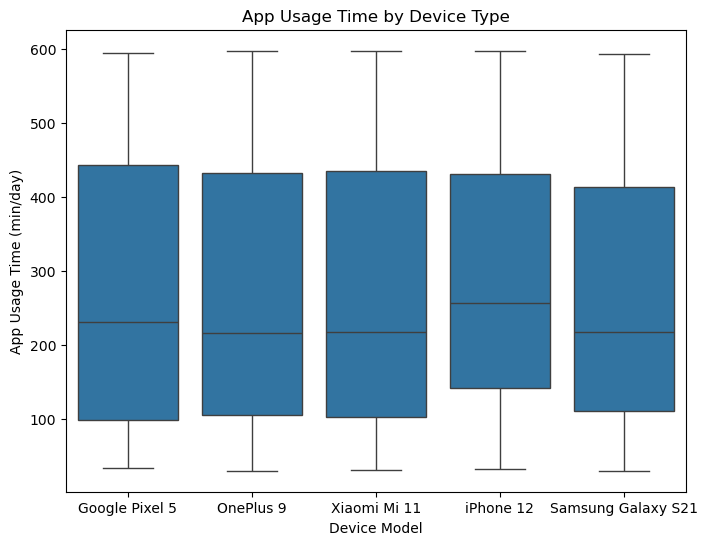

In [23]:
# App Usage Time by Device

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Device Model', y='App Usage Time (min/day)')
plt.title('App Usage Time by Device Type')
plt.xlabel('Device Model')
plt.ylabel('App Usage Time (min/day)')
plt.show()

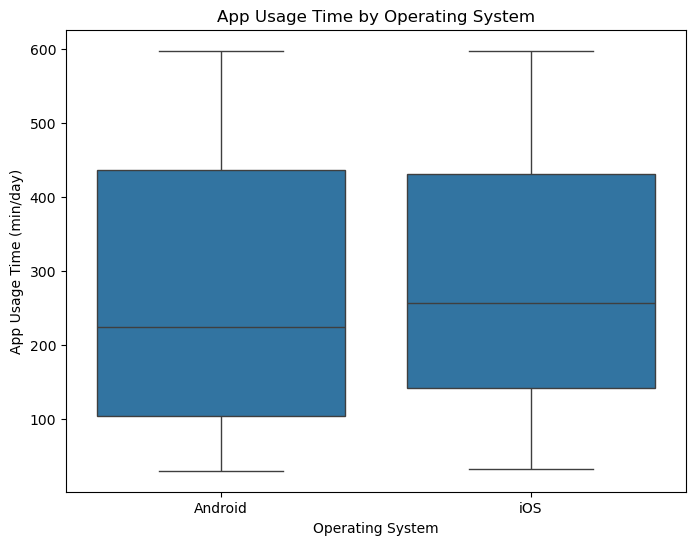

In [24]:
# App Usage Time by Operating System

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Operating System', y='App Usage Time (min/day)')
plt.title('App Usage Time by Operating System')
plt.xlabel('Operating System')
plt.ylabel('App Usage Time (min/day)')
plt.show()

## Models - Linear Regression, Random Forest, XGBoost

In [25]:
# Get the shape of the data
df.shape

(700, 13)

In [26]:
# Set Features and Target
X = df.drop(columns=['App Usage Time (min/day)', 'Age Group'])
y = df['App Usage Time (min/day)']

categorical_features = ['Device Model', 'Operating System', 'Gender']
numerical_features = ['Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 
                      'Number of Apps Installed', 'Data Usage (MB/day)']

#Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features), 
    ('cat', OneHotEncoder(), categorical_features)
])
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Linear Regression Model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train and evaluate
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print Results
print('Linear Regression Results')
print(f'MAE: {mae_lr}')
print(f'MSE: {mse_lr}')
print(f'RMSE: {np.sqrt(mse_lr)}')
print(f'R^2: {r2_score(y_test, y_pred_lr)}')

Linear Regression Results
MAE: 35.051906212117125
MSE: 1885.1893380352788
RMSE: 43.41876711786366
R^2: 0.9312093987635787


In [28]:
# Random Forest Model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Train and evaluate
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest Results:')
print(f'MAE: {mae_rf}')
print(f'MSE: {mse_rf}')
print(f'RMSE: {np.sqrt(mse_rf)}')
print(f'R^2: {r2_score(y_test, y_pred_rf)}')

Random Forest Results:
MAE: 27.30028571428572
MSE: 1231.0872942857143
RMSE: 35.08685358201436
R^2: 0.9550775970138398


In [29]:
# XGBoost Model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Train and evaluate
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print('XGBoost Results:')
print(f'MAE: {mae_xgb}')
print(f'MSE: {mse_xgb}')
print(f'RMSE: {np.sqrt(mse_xgb)}')
print(f'R^2: {r2_score(y_test, y_pred_xgb)}')



XGBoost Results:
MAE: 29.092661203656878
MSE: 1452.941171127899
RMSE: 38.11746543420613
R^2: 0.9469821440708955


In [30]:
# Put the scores into a dataframe 
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rf, mae_xgb],
    'MSE': [mse_lr, mse_rf, mse_xgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R2': [r2_lr, r2_rf, r2_xgb]
})

print(metrics_df)

               Model        MAE          MSE       RMSE        R2
0  Linear Regression  35.051906  1885.189338  43.418767  0.931209
1      Random Forest  27.300286  1231.087294  35.086854  0.955078
2            XGBoost  29.092661  1452.941171  38.117465  0.946982


## Graphing Model Performance

## Residuals


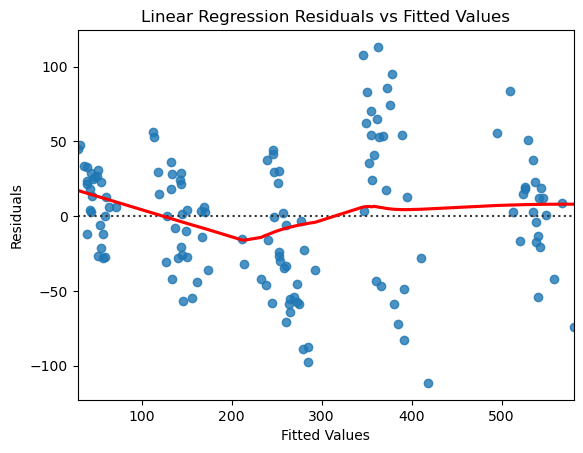

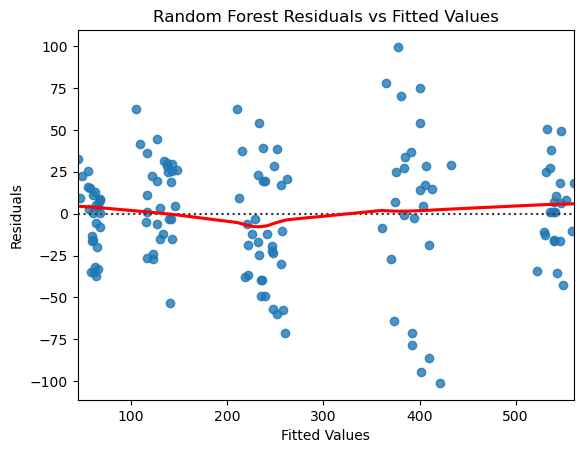

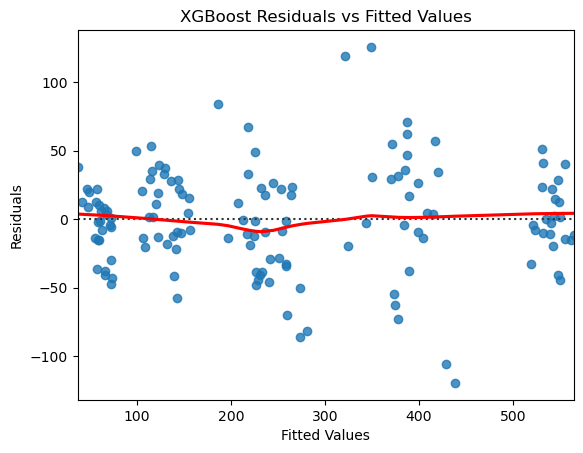

In [31]:
# Residual plot
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

residuals = {'Linear Regression': [y_pred_lr, residuals_lr], 'Random Forest': [y_pred_rf, residuals_rf], 'XGBoost': [y_pred_xgb, residuals_xgb]}

for key, model_residuals in residuals.items():
    sns.residplot(x=model_residuals[0], y=model_residuals[1], lowess=True, line_kws={'color': 'red'})
    plt.title(f'{key} Residuals vs Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

## Model Analysis
From the performance metrics and graphs above, we can see that the Random Forest model performs the best. 
It has the lowest RMSE and highest R^2 score.

In [32]:
# Let's get the feature importance from the Random Forest Model
rf_model = rf_pipeline.named_steps['model']

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out(X_train.columns)

# Get the feature importances
feature_importance = rf_model.feature_importances_

# Create a dataframe to hold the results
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                 Feature  Importance
2          num__Number of Apps Installed    0.368334
3               num__Data Usage (MB/day)    0.300794
1           num__Battery Drain (mAh/day)    0.288011
0        num__Screen On Time (hours/day)    0.037086
4       cat__Device Model_Google Pixel 5    0.000895
6   cat__Device Model_Samsung Galaxy S21    0.000852
5            cat__Device Model_OnePlus 9    0.000750
7         cat__Device Model_Xiaomi Mi 11    0.000731
12                      cat__Gender_Male    0.000723
11                    cat__Gender_Female    0.000583
10             cat__Operating System_iOS    0.000501
8            cat__Device Model_iPhone 12    0.000387
9          cat__Operating System_Android    0.000354


## Which features were the most important for predicting app usage time?

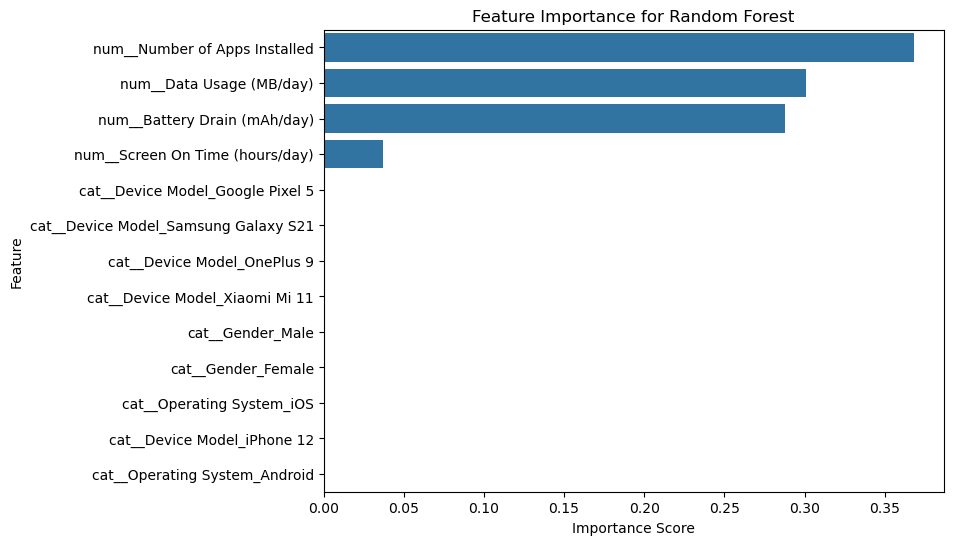

In [33]:
# Plot the feature importance
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()